# Analysis of eulerian field of the NWES

In [1]:
import numpy as np

In [1]:
# import needed packages
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
from decimal import Decimal
from datetime import datetime, timedelta
# from analysis_functions import trajectory_length,  make_PDF, Haversine, running_mean
import sys
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/simulations")
from helper import create_filelist

plt.style.use('../python_style_Meike.mplstyle')

Rearth = 6371 * 10**3 # in k
Omega_earth =7.2921 * (10**-5) # angular velocity earth in rad/s
deg2rad = np.pi / 180.

# for fieldsets
field_directory = ('/storage/shared/oceanparcels/input_data/CopernicusMarineService/'
                   'NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/')
input_filename_field_nologin = ('CMEMS_v6r1_NWS_PHY_NRT_NL_01hav3D_'
                                '{year_t:04d}{month_t:02d}{day_t:02d}_'
                                '{year_t:04d}{month_t:02d}{day_t:02d}_'
                                'R{year_tplus:04d}{month_tplus:02d}{day_tplus:02d}_HC01.nc')

input_filename_metoffice = ('metoffice_foam1_amm15_NWS_CUR_'
                            'b{year_t:04d}{month_tr:02d}{day_t:02d}_'
                            'hi{year_tplus:04d}{month_tplus:02d}{day_tplus:02d}.nc')



colorlist=np.array(['c','purple','orange','navy','red','black','green'])

In [2]:
# general settings
B = 0.68
tau = 2759.97
runtime =  timedelta(days=30)# timedelta(days=10)
starttimes=np.array([datetime(2023, 9, 1, 0, 0, 0, 0),
                      datetime(2023, 10, 1, 0, 0, 0, 0),
                      datetime(2023, 11, 1, 0, 0, 0, 0),
                      datetime(2023, 12, 1, 0, 0, 0, 0),
                      datetime(2024, 1, 1, 0, 0, 0, 0),
                      datetime(2024, 2, 1, 0, 0, 0, 0)])

date_new = datetime(2023, 9, 1, 0, 0, 0, 0)



In [2]:
dflow = xr.open_dataset('/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/input_data/cmems_mod_nws_phy_anfc_0.027deg-3D_P1D-m_1743500428567.nc')

In [3]:
dflow

<xarray.Dataset> Size: 132MB
Dimensions:    (time: 32, depth: 1, latitude: 550, longitude: 936)
Coordinates:
  * time       (time) datetime64[ns] 256B 2023-09-01 2023-09-02 ... 2023-10-02
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 2kB 46.03 46.05 46.08 ... 61.22 61.25 61.28
  * longitude  (longitude) float32 4kB -16.0 -15.97 -15.94 ... 9.918 9.946 9.974
Data variables:
    uo         (time, depth, latitude, longitude) float32 66MB ...
    vo         (time, depth, latitude, longitude) float32 66MB ...
Attributes:
    Conventions:       CF-1.11
    title:             Ocean 3D daily mean fields for the North West Shelf (N...
    institution:       NOW Systems (Spain)
    source:            NEMO3.6
    contact:           https://marine.copernicus.eu/contact
    references:        http://marine.copernicus.eu/
    comment:           
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  NWSHELF_ANALYSISFORECAST_PHY_004_013
    subset:datasetId:  cmems_mod_nws_phy_anfc_0.027deg-3D_P1D-m_202411
    subset:date:       2025-04-01T09:40:28.567Z

In [ ]:

dflow = xr.open_mfdataset('/storage/shared/oceanparcels/input_data/CopernicusMarineService/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/CMEMS_v6r1_NWS_PHY_NRT_NL_01hav3D_20230901_20230901_R20230902_HC01.nc')


## Eulerian analysis fieldsets
Below we investigate the Eulerian properties of the velocity fieldset used. That is:
- magnitude of spacial and temporal gradients in the velocity
- typical correlation length velocity  

With these values we can estimate if we expect an effect from Inertia or not

### Calculate and plot material derivatives fields
We import the fieldsets 1 month at a time (as is used in the simulations).  
Before 1/9/2023 we import the data from metuoffice uk, after 1/9/2023 we   
import data from nologin Spain.

In [3]:
# import data
starttime = starttimes[0]
print(starttime)

endtime = starttime + runtime
dt_field = timedelta(days=1)

if (starttime < date_new):
    input_filename =  input_filename_metoffice
    dt_name_field = timedelta(days=2)
else: 
    input_filename = input_filename_field_nologin
    dt_name_field = timedelta(days=1)

oceanfiles = create_filelist(field_directory, input_filename,
                               starttime, endtime, dt_field, dt_name_field)

dflow = xr.open_mfdataset(oceanfiles, drop_variables = ['thetao','so','depth'])
# only keep upper layer
dflow['uo'] = dflow['uo'][:,0,:,:]
dflow['vo'] = dflow['vo'][:,0,:,:]
dlon = (dflow['longitude'][1]-dflow['longitude'][0]).values
dlat = (dflow['latitude'][1]-dflow['latitude'][0]).values
dtime = (dflow['time'][1]-dflow['time'][0]).values


time, lon, lat = (dflow['time'].values, dflow['longitude'].values,dflow['latitude'].values)
LON, LAT = np.meshgrid(lon,lat)
LON_dx, LAT_dx = np.meshgrid(lon[0:-1]+0.5*dlon,lat)
LON_dy, LAT_dy = np.meshgrid(lon,lat[0:-1]+0.5*dlat)
# dflow=dflow.fillna(value={"uo":0,"vo":0})


2023-09-01 00:00:00


In [4]:
lon_min = dflow['longitude'][0].values
lon_max = dflow['longitude'][-1].values
lat_min = dflow['latitude'][0].values
lat_max = dflow['latitude'][-1].values
print(lon_min)
print(lon_max)
print(lat_min)
print(lat_max)

-15.996015
9.977004
46.003643
61.281887


In [5]:
# use xarray diff function to calculate derivatives 
# define jacobean 
Jtime = 1/3600 # seconds per hour
Jx = 1 / (2 * Rearth * np.arcsin(np.sqrt(0.5 * ( np.cos(LAT[:,1:] * deg2rad)**2) * (1 - np.cos(dlon * deg2rad)))))
Jy = 1 / (Rearth * dlat * deg2rad)

# dimensions (time, lat, lon)
dvdt = dflow['vo'].diff(dim='time',n=1,label="upper") * Jtime
dvdx = dflow['vo'].diff(dim='longitude',n=1,label="upper") * Jx
dvdy = dflow['vo'].diff(dim='latitude',n=1,label="upper") * Jy

dudt = dflow['uo'].diff(dim='time',n=1,label="upper") * Jtime
dudx = dflow['uo'].diff(dim='longitude',n=1,label="upper") * Jx
dudy = dflow['uo'].diff(dim='latitude',n=1,label="upper") * Jy


# 
dvdx['longitude']=dvdx['longitude']-0.5*dlon
dudx['longitude']=dudx['longitude']-0.5*dlon
dvdy['latitude']=dvdy['latitude']-0.5*dlat
dvdy['latitude']=dvdy['latitude']-0.5*dlat
dvdt['time']=dvdt['time']-0.5*dtime
dudt['time']=dudt['time']-0.5*dtime

In [6]:
# calculate u and v component material derivative field
dvdx_agrid=dvdx.interp(longitude=lon[1:-1])[1:-1,1:-1,:]
dudx_agrid=dudx.interp(longitude=lon[1:-1])[1:-1,1:-1,:]
dvdy_agrid=dvdy.interp(latitude=lat[1:-1])[1:-1,:,1:-1]
dudy_agrid=dudy.interp(latitude=lat[1:-1])[1:-1,:,1:-1]

dvdt_agrid = dvdt.interp(time=time[1:-1])[:,1:-1,1:-1]
dudt_agrid = dudt.interp(time=time[1:-1])[:,1:-1,1:-1]
u = dflow['uo'][1:-1,1:-1,1:-1]
v = dflow['vo'][1:-1,1:-1,1:-1]
DuDt = (dudt_agrid + u * dudx_agrid + v * dudy_agrid).load()
DvDt = (dvdt_agrid + u * dvdx_agrid + v * dvdy_agrid).load()

f = xr.DataArray( 2 * Omega_earth * np.sin(lat * deg2rad),dims='latitude')
coriolis_u = - (dflow['vo'] * f)[1:-1,1:-1,1:-1]
coriolis_v = (dflow['uo'] * f)[1:-1,1:-1,1:-1]
vorticity = (dvdx_agrid-dudy_agrid)
# calculate Q, Qa value (Okuba-Weis parameter)
ff=f[1:-1]

Omega_sq = 0.5 * (dvdx_agrid - dudy_agrid)**2 
Omega_a_sq = 0.5 * ((dvdx_agrid - dudy_agrid)**2 + ff**2 + 2 * (dvdx_agrid - dudy_agrid) * ff)
S_sq = 2*dudx_agrid**2+2*dvdy_agrid**2+dudy_agrid**2+dvdx_agrid**2+2*dvdx_agrid*dudy_agrid
Q = 0.5*(Omega_sq-S_sq)
Qa = 0.5*(Omega_a_sq-S_sq)

up = u + tau * 2 * (1 - B) / (1 + 2 * B) * (DuDt + coriolis_u)
vp = v + tau * 2 * (1 - B) / (1 + 2 * B) * (DvDt + coriolis_v)


#### Plotting fields

(51.2, 54.0)

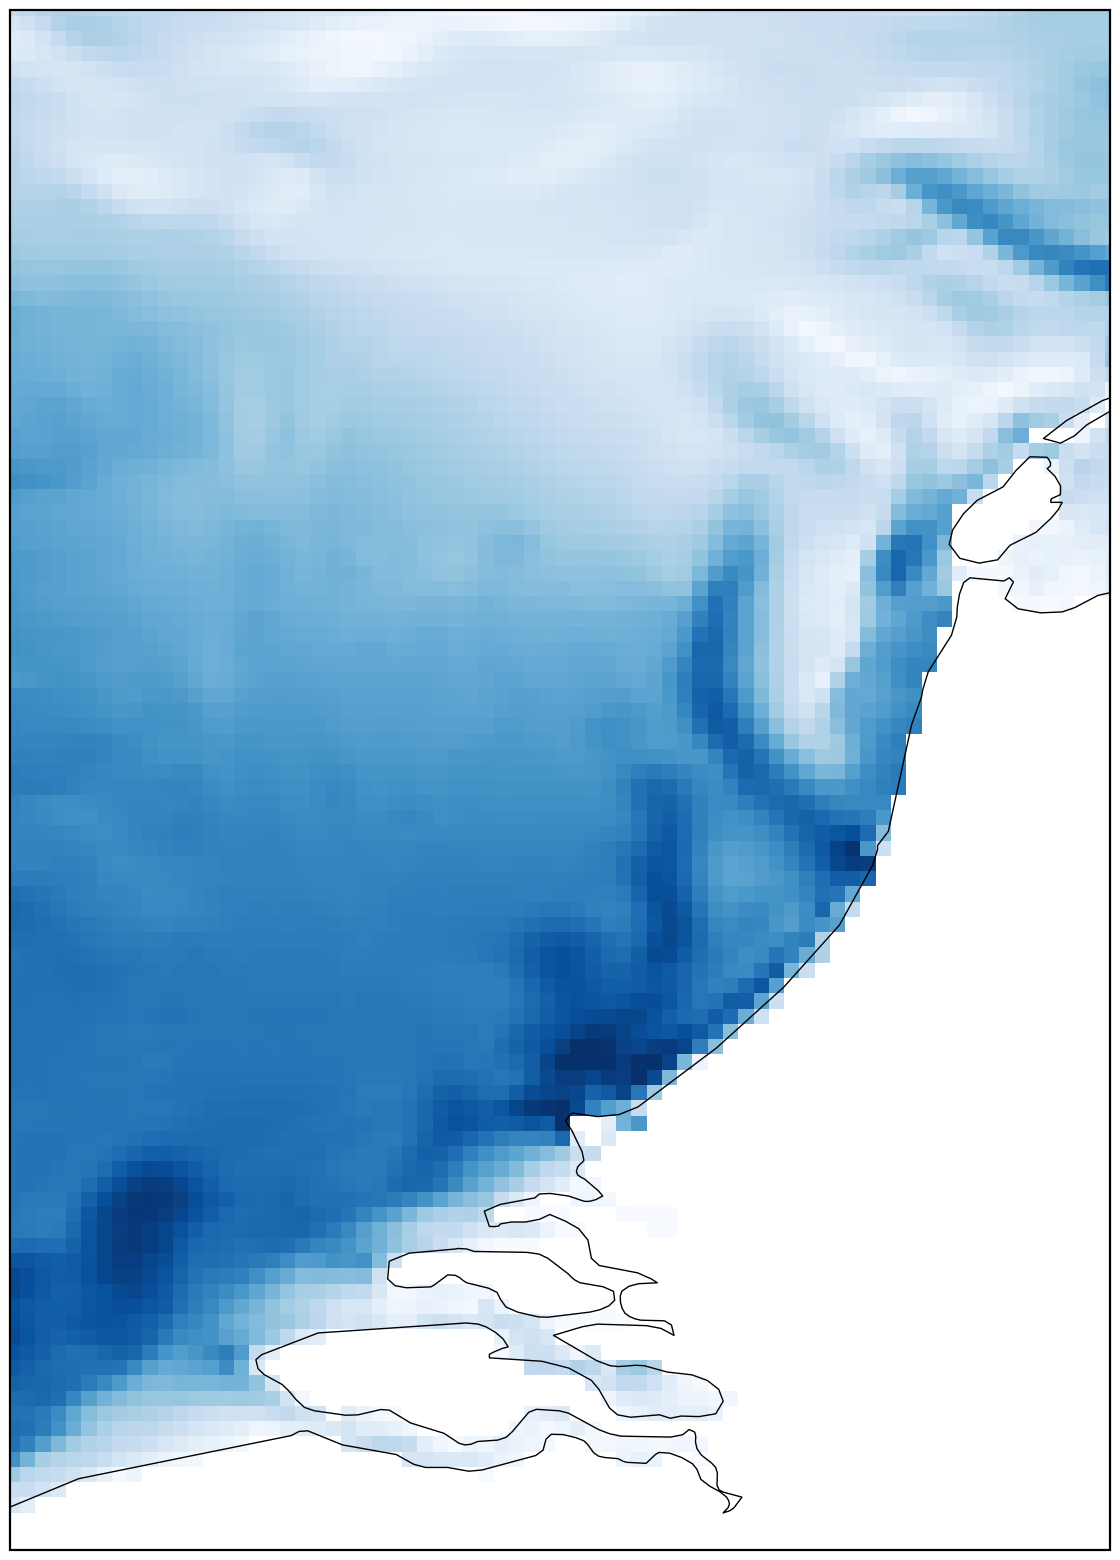

In [27]:
# plot velocity field
plot_time = 10.5 # in days 
tindex=int(plot_time*24)
fig, ax = plt.subplots(figsize=(20,20),subplot_kw={'projection':ccrs.PlateCarree()})
pcm0 =ax.pcolormesh(LON, LAT ,np.sqrt(dflow['uo'][tindex]**2+dflow['vo'][tindex]**2),cmap='Blues',vmin=0,vmax=1)
ax.coastlines()  
ax.set_xlabel('longitude [$^{\\circ}$]')
ax.set_ylabel('latitude [$^{\\circ}$]')
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#             linewidth=0.1, color='gray', alpha=0, linestyle='--')
# gl.top_labels = False
# gl.right_labels = False
# gl.xlabel_style = {'size': 20}
# gl.ylabel_style =  {'size': 20}
ax.set_xlim(3,5)
ax.set_ylim(51.2,54)


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


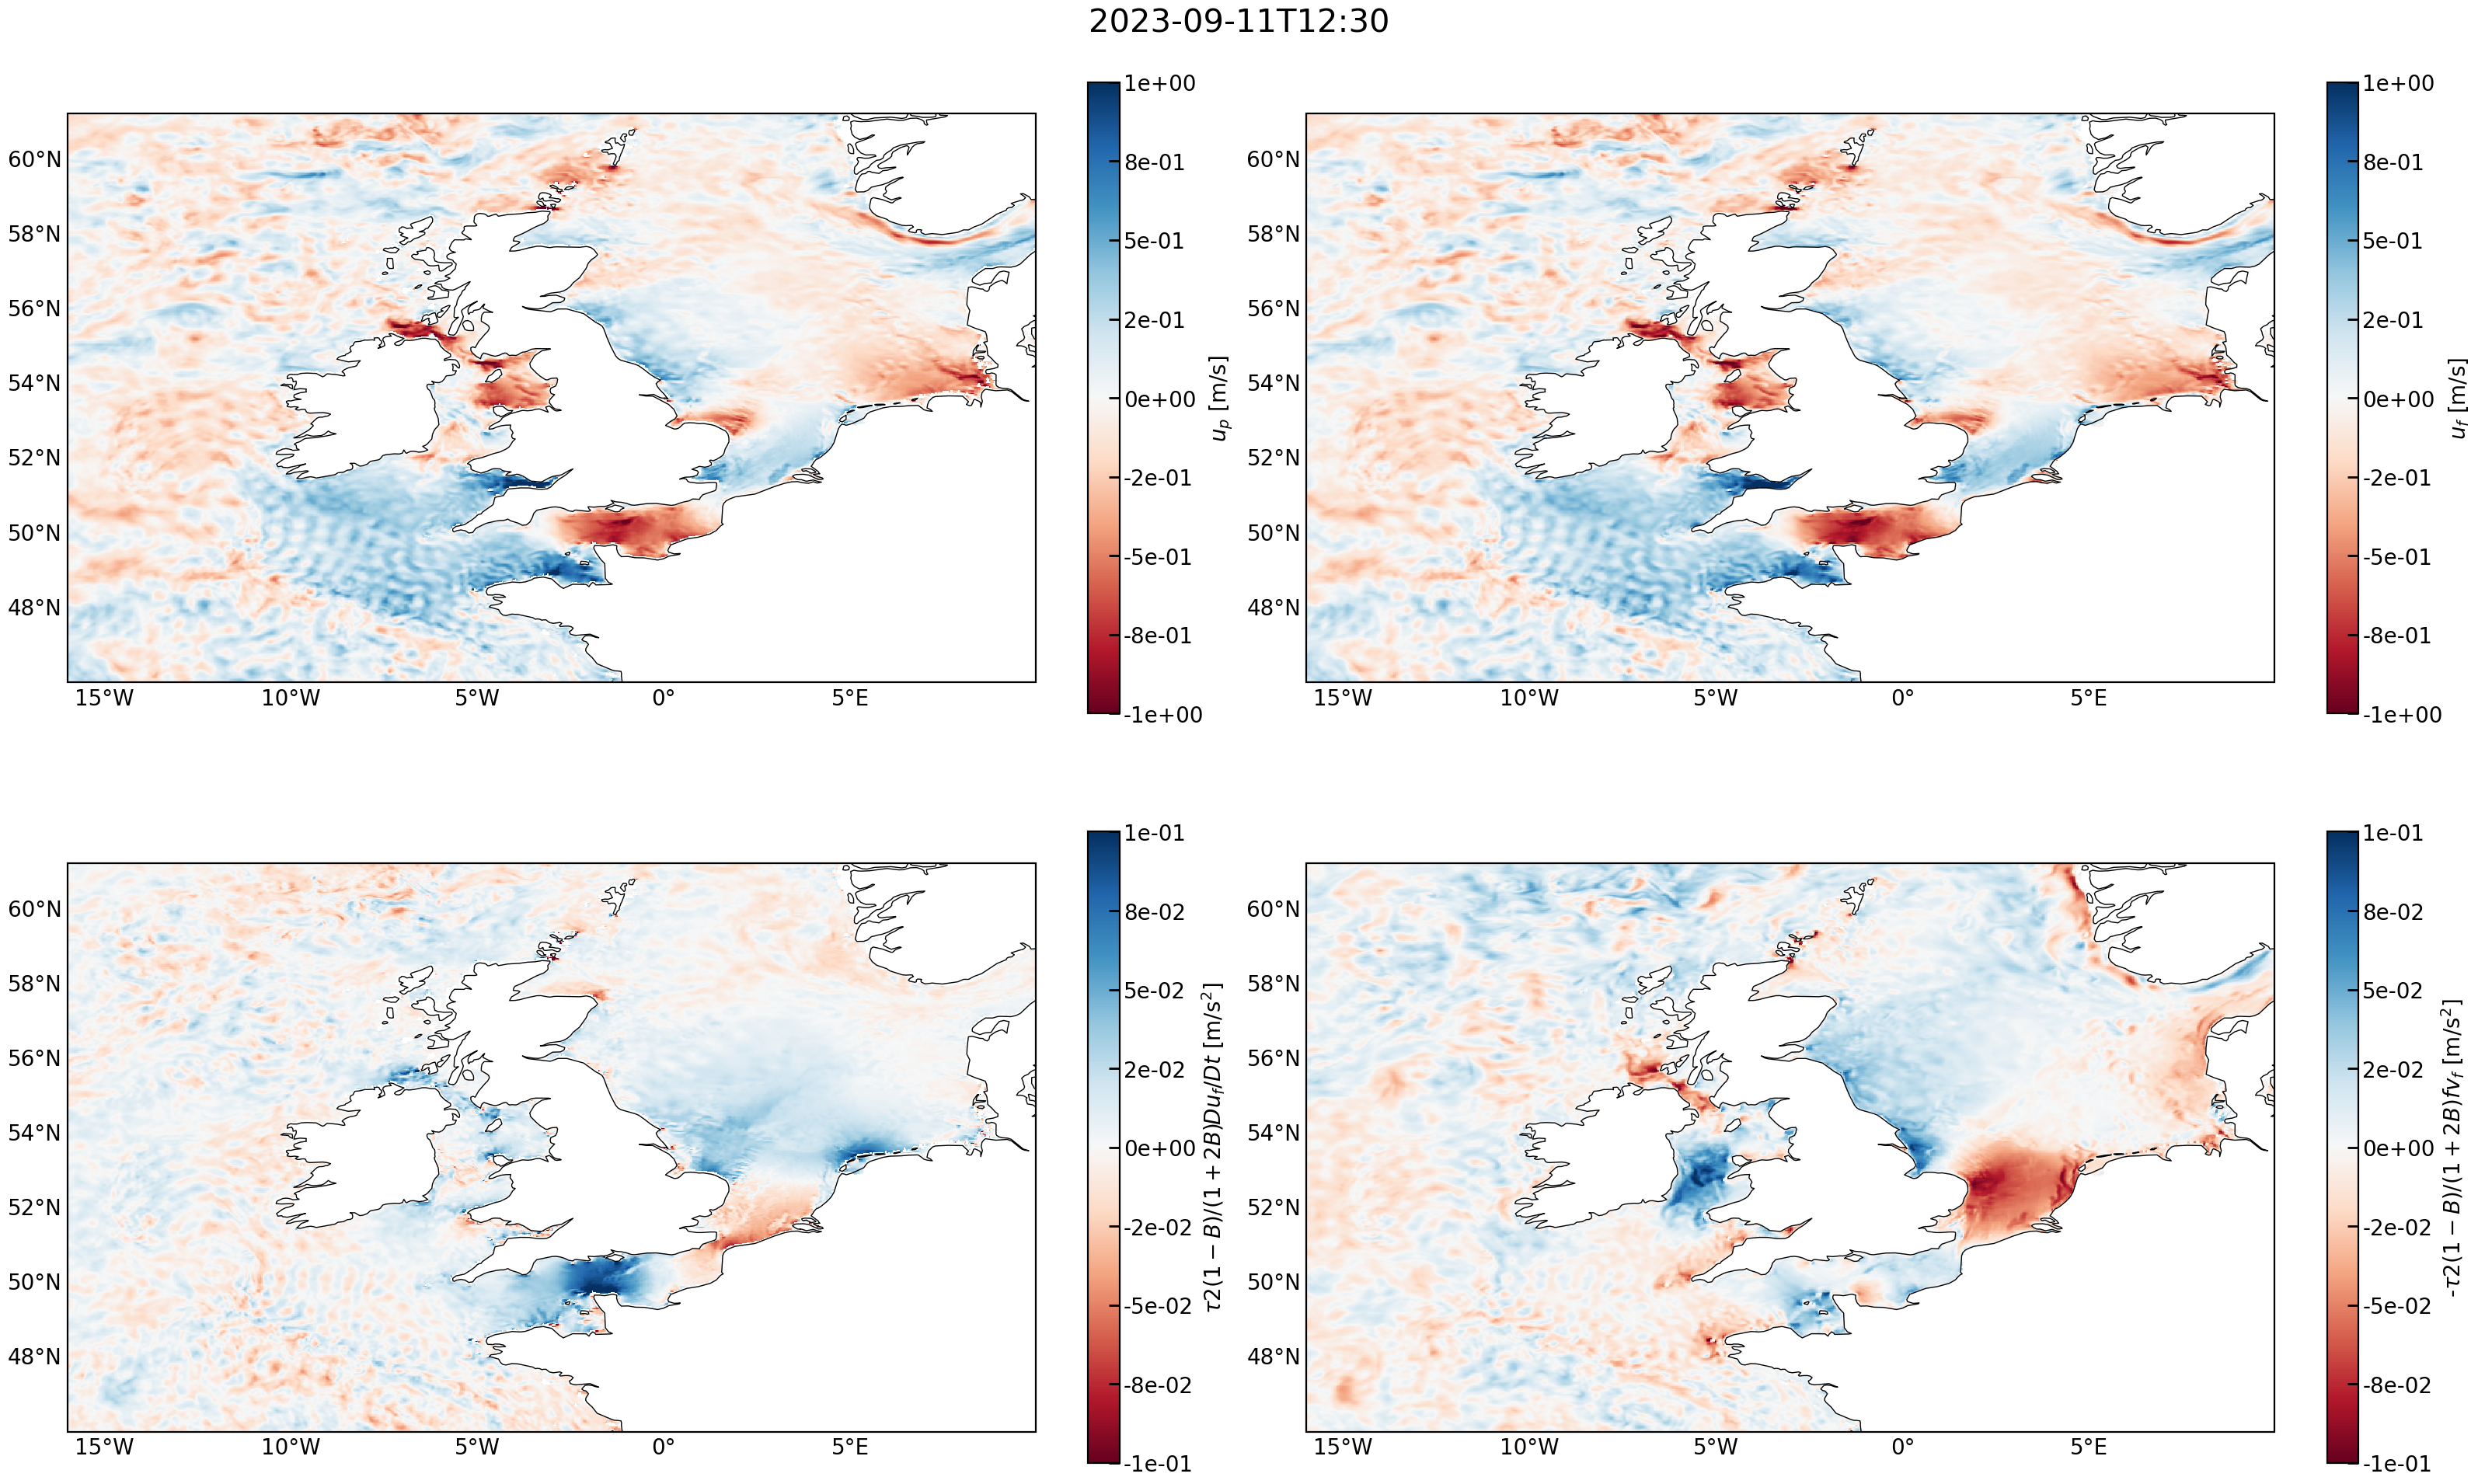

In [7]:
# plot components velocity fields next to eachother to compare:
# options
day_averaged = False
plot_time = 10.5 # in days 

fig, axs = plt.subplots(2,2,figsize=(32,20),subplot_kw={'projection':ccrs.PlateCarree()})
tindex=int(plot_time*24)
if(day_averaged == True):
    pcm0 = axs[0,0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] ,up[tindex:tindex+24].mean(dim='time').values,cmap='RdBu',vmin=-1,vmax=1)
    pcm1 = axs[0,1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] ,u[tindex:tindex+24].mean(dim='time').values,cmap='RdBu',vmin=-1,vmax=1)
    pcm2 = axs[1,0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] ,tau * 2* (1 - B) / (1 + 2 * B)*DuDt[tindex:tindex+24].mean(dim='time').values,cmap='RdBu',vmin=-0.1,vmax=0.1)
    pcm3 = axs[1,1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] ,tau * 2* (1 - B) / (1 + 2 * B)*coriolis_u[tindex:tindex+24].mean(dim='time').values,cmap='RdBu',vmin=-0.1,vmax=0.1)
   
else:
    pcm0 = axs[0,0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] ,up[tindex].values,cmap='RdBu',vmin=-1,vmax=1)
    pcm1 = axs[0,1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] ,u[tindex].values,cmap='RdBu',vmin=-1,vmax=1)
    pcm2 = axs[1,0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] ,tau * 2* (1 - B) / (1 + 2 * B)*DuDt[tindex].values,cmap='RdBu',vmin=-0.1,vmax=0.1)
    pcm3 = axs[1,1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] ,tau * 2* (1 - B) / (1 + 2 * B)*coriolis_u[tindex].values,cmap='RdBu',vmin=-0.1,vmax=0.1)
date = dflow['time'][tindex].values
cxbar=fig.colorbar(pcm0,label='$u_p$ [m/s]',fraction=0.03,  format='%.0e')
cxbar=fig.colorbar(pcm1,label='$u_f$ [m/s]',fraction=0.03, format='%.0e')
cxbar=fig.colorbar(pcm2,label='$\\tau 2(1-B)/(1+2B) Du_f/Dt$ [m/s$^2$]',fraction=0.03,  format='%.0e')
cxbar=fig.colorbar(pcm3,label='-$\\tau 2(1-B)/(1+2B) f v_f$ [m/s$^2$]',fraction=0.03, format='%.0e')
for a in range(0,2,1):
    for b in range (0,2,1):
        axs[a,b].coastlines()  
        axs[a,b].set_xlabel('longitude [$^{\\circ}$]')
        axs[a,b].set_ylabel('latitude [$^{\\circ}$]')
        gl = axs[a,b].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.1, color='gray', alpha=0, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 20}
        gl.ylabel_style =  {'size': 20}
    # axs[a].set_xlim(-3,9.5)
    # axs[a].set_ylim(50,60)

date = dflow['time'][tindex].values
if(day_averaged==True):
    fig.suptitle(f'daily average {np.datetime64(date,'D')}', fontsize=30) #options, Y, M, D, h, m, s for np.datetime
else:
    fig.suptitle(f'{np.datetime64(date,'m')}', fontsize=30)
    fig.tight_layout( )
    fig.savefig(f'../figures/eulerian_field/plots/uf_up_and_components_x_{np.datetime64(date,'m')}.pdf')




In [ ]:
# plot components velocity fields next to eachother to compare:
# options
day_averaged = False
plot_time =10.5 # in days 

fig, axs = plt.subplots(1,2,figsize=(32,8),subplot_kw={'projection':ccrs.PlateCarree()})
tindex=int(plot_time*24)
if(day_averaged == True):
    pcm0 = axs[0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] ,Q[tindex:tindex+24].mean(dim='time').values,cmap='RdBu',vmin=-10**(-10),vmax=10**(-10))
    pcm1 = axs[1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] ,Qa[tindex:tindex+24].mean(dim='time').values,cmap='RdBu',vmin=-10**(-8),vmax=10**(-8))
    
else:
    pcm0 = axs[0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] ,(tau)**2*Qa[tindex].values,cmap='RdBu',vmin=-0.05,vmax=0.05)
    pcm1 = axs[1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] ,(tau)**2*Q[tindex].values,cmap='RdBu',vmin=-0.05,vmax=0.05)

date = dflow['time'][tindex].values
cxbar=fig.colorbar(pcm0,label='$Q_a \\tau^2$ ',fraction=0.03,  format='%.0e')
cxbar=fig.colorbar(pcm1,label='$Q \\tau^2$ ',fraction=0.03, format='%.0e')

for a in range(0,2,1):
        axs[a].coastlines()  
        axs[a].set_xlabel('longitude [$^{\\circ}$]')
        axs[a].set_ylabel('latitude [$^{\\circ}$]')
        gl = axs[a].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.1, color='gray', alpha=0, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 20}
        gl.ylabel_style =  {'size': 20}
    # axs[a].set_xlim(-3,9.5)
    # axs[a].set_ylim(50,60)

date = dflow['time'][tindex].values
if(day_averaged==True):
    fig.suptitle(f'daily average {np.datetime64(date,'D')}', fontsize=30) #options, Y, M, D, h, m, s for np.datetime
else:
    fig.suptitle(f'{np.datetime64(date,'m')}', fontsize=30)
    # fig.tight_layout( )
    # fig.savefig(f'../figures/eulerian_field/plots/uf_up_and_components_x_{np.datetime64(date,'m')}.pdf')




In [84]:
# make movie Qa: 
# pcm0 = axs[0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] ,(tau)**2*Qa[tindex].values,cmap='RdBu',vmin=-0.05,vmax=0.05)
for tindex in range(0,24*10,1):#range(0,24*30-2,1):

    fig, ax = plt.subplots(figsize=(12,10),subplot_kw={'projection':ccrs.PlateCarree()})
    ax.coastlines()   

    pcm = ax.pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], (tau)**2*Qa[tindex].values,cmap='RdBu',vmin=-0.05,vmax=0.05)

    ax.set_xlabel('longitude [$^{\\circ}$]')
    ax.set_ylabel('latitude [$^{\\circ}$]')

    cxbar=fig.colorbar(pcm,label=f'$Q_a \\tau^2$',fraction=0.03)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    ax.set_title(f'{time[tindex]}', fontsize=20)
    # ax.set_xlim(-3,9.5)
    # ax.set_ylim(51,61)
    fig.savefig(f'../figures/eulerian_field/frames/september/velocity/Qa_field_hourly{tindex:04d}.png')
    plt.close(fig)

In [ ]:
loc = 'NWES'
B = 0.68
tau = 2759.97
runtime=timedelta(30)
nparticles = 88347 # 52511
displacement = 100 #m
land_handling = 'anti_beaching'
coriolis = True
chunck_time=100
path = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial/'
ds = xr.open_dataset(path+'NWES_start2023_09_01_end2023_10_01_RK4_B0680_tau2759_anti_beaching_cor_True_vorticity_False.zarr',
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)

fig, ax = plt.subplots(figsize=(12,10),subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()   
tindex=719

pcm = ax.pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], (tau)**2*Qa[tindex].values,cmap='RdBu',vmin=-0.05,vmax=0.05)
ax.plot(ds.lon[::,tindex],ds.lat[::,tindex],'.',color='black',alpha=1,markersize=1)

ax.set_xlabel('longitude [$^{\\circ}$]')
ax.set_ylabel('latitude [$^{\\circ}$]')

cxbar=fig.colorbar(pcm,label=f'$Q_a \\tau^2$',fraction=0.03)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}


ax.set_title(f'{time[tindex]}', fontsize=20)
ax.set_xlim

In [ ]:
print(ds.lon[tindex])

In [ ]:
# plot magnitude Du_f/Dt and fxu_f next to eachother to compare:
# options
day_averaged = False
plot_time = 10.5 # in days 
fig, axs = plt.subplots(2,2,figsize=(32,20),subplot_kw={'projection':ccrs.PlateCarree()})
tindex=int(plot_time*24)
if(day_averaged == True):
    pcm0 = axs[0,0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], np.sqrt(up**2+vp**2)[tindex:tindex+24].mean(dim='time').values,cmap='Blues',vmin=0,vmax=1)
    pcm1 = axs[0,1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], np.sqrt(u**2+v**2)[tindex:tindex+24].mean(dim='time').values,cmap='Blues',vmin=0,vmax=1)
    pcm2 = axs[1,0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] , 2*(1-B) / (1+2*B) * tau * np.sqrt(DuDt**2+DvDt**2)[tindex:tindex+24].mean(dim='time').values,cmap='Reds',vmin=0,vmax=0.1)
    pcm3 = axs[1,1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], 2*(1-B) / (1+2*B) * tau *np.sqrt(coriolis_u**2+coriolis_v**2)[tindex:tindex+24].mean(dim='time').values,cmap='Reds',vmin=-0,vmax=0.1)
    
else:
    pcm0 = axs[0,0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], np.sqrt(up**2+vp**2)[tindex].values,cmap='Blues',vmin=0,vmax=1)
    pcm1 = axs[0,1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], np.sqrt(u**2+v**2)[tindex].values,cmap='Blues',vmin=0,vmax=1)
    pcm2 = axs[1,0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] , 2*(1-B) / (1+2*B) * tau * np.sqrt(DuDt**2+DvDt**2)[tindex].values,cmap='Reds',vmin=0,vmax=0.1)
    pcm3 = axs[1,1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], 2*(1-B) / (1+2*B) * tau *np.sqrt(coriolis_u**2+coriolis_v**2)[tindex].values,cmap='Reds',vmin=-0,vmax=0.1)
    
date = dflow['time'][tindex].values
cxbar=fig.colorbar(pcm0,label='$|\\boldsymbol{u}_p|$ [m/s]',fraction=0.03,  format='%.0e')
cxbar=fig.colorbar(pcm1,label='$|\\boldsymbol{u}_f|$ [m/s]',fraction=0.03,  format='%.0e')
cxbar=fig.colorbar(pcm2,label='$\\tau 2(1-B)/(1+2B)|D\\boldsymbol{u}_f/Dt|$ [m/s]',fraction=0.03,  format='%.0e')
cxbar=fig.colorbar(pcm3,label='-$\\tau 2(1-B)/(1+2B)|f \\times \\boldsymbol{u}_f|$ [m/s]',fraction=0.03, format='%.0e')
for a in range(0,2,1):
    for b in range(0,2,1):
        axs[a,b].coastlines()  
        axs[a,b].set_xlabel('longitude [$^{\\circ}$]')
        axs[a,b].set_ylabel('latitude [$^{\\circ}$]')
        gl = axs[a,b].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.1, color='gray', alpha=0, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 20}
        gl.ylabel_style =  {'size': 20}
    # axs[a].set_xlim(-3,9.5)
    # axs[a].set_ylim(50,60)

date = dflow['time'][tindex].values
if(day_averaged==True):
    fig.suptitle(f'daily average {np.datetime64(date,'D')}', fontsize=30) #options, Y, M, D, h, m, s for np.datetime
    fig.tight_layout()
    fig.savefig(f'../figures/eulerian_field/plots/magnitude_uf_up_and_components_{np.datetime64(date,'D')}.pdf')
else:
    fig.suptitle(f'{np.datetime64(date,'m')}', fontsize=30)
    fig.tight_layout()
    fig.savefig(f'../figures/eulerian_field/plots/magnitude_uf_up_and_components_{np.datetime64(date,'m')}.pdf')



### movies eulerian velocity field

In [ ]:
# make frames for movie of u/v component velocity or speed plotted hourly for 2 days
set_component = 'speed' # options are u, v or speed 
if (set_component == 'u'):
    flowfield = dflow.uo
    vmin=-1.5
    vmax=1.5
    cmap = 'RdBu'
elif (set_component == 'v'):
    flowfield = dflow.vo
    vmin=-1.5
    vmax=1.5
    cmap = 'RdBu'
elif (set_component == 'speed'):
    flowfield = np.sqrt(dflow.uo**2+dflow.vo**2)
    vmin=0
    vmax=1.5
    cmap = 'Blues'
else: 
    raise ValueError(f'Error {set_component} should be u, v or speed!')


for tindex in range(0,24*2,1):#range(0,24*30-2,1):

    fig, ax = plt.subplots(figsize=(12,10),subplot_kw={'projection':ccrs.PlateCarree()})
    ax.coastlines()   

    pcm = ax.pcolormesh(LON, LAT, flowfield[tindex].values,cmap=cmap,vmin=vmin,vmax=vmax)

    ax.set_xlabel('longitude [$^{\\circ}$]')
    ax.set_ylabel('latitude [$^{\\circ}$]')

    cxbar=fig.colorbar(pcm,label=f'{set_component} [m/s]',fraction=0.03)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    ax.set_title(f'{time[tindex]}', fontsize=20)
    # ax.set_xlim(-3,9.5)
    # ax.set_ylim(51,61)
    fig.savefig(f'../figures/eulerian_field/frames/september/velocity/{set_component}_field_hourly{tindex:04d}.png')
    plt.close(fig)


In [ ]:
# make frames for movie of u/v component velocity or speed averaged over 1 day (=2 tidal cycles)) for 1 month 
set_component = 'speed' # options are u, v or speed 

if (set_component == 'u'):
    flowfield = dflow.uo
    vmin=-1.5
    vmax=1.5
    cmap = 'RdBu'
elif (set_component == 'v'):
    flowfield = dflow.vo
    vmin=-1.5
    vmax=1.5
    cmap = 'RdBu'
elif (set_component == 'speed'):
    flowfield = np.sqrt(dflow.uo**2+dflow.vo**2)
    vmin=0
    vmax=1.5
    cmap = 'Blues'
else: 
    raise ValueError(f'Error {set_component} should be u, v or speed!')

for tindex in range(0,30,1):#range(0,24*30-2,1):
    fig, ax = plt.subplots(figsize=(12,10),subplot_kw={'projection':ccrs.PlateCarree()})
    ax.coastlines()  
    pcm = ax.pcolormesh(LON, LAT, flowfield[tindex*24:(tindex+1)*24].mean(dim='time').values,cmap=cmap, vmin=vmin, vmax=vmax)

    ax.set_title(f'{time[tindex*24]}', fontsize=20)
    ax.set_xlabel('longitude [$^{\\circ}$]')
    ax.set_ylabel('latitude [$^{\\circ}$]')

    cxbar=fig.colorbar(pcm,label=f'{set_component} [m/s]',fraction=0.03)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}

    

    fig.savefig(f'../figures/eulerian_field/frames/september/velocity/{set_component}_field_day_avaraged{tindex:04d}.png')
    plt.close(fig)


### movies material derivatives

In [ ]:
# make movie hourly material derivative for u component, v component, speed or vorticity for 2 days
set_component = 'u' # options are u/v/speed/vorticity

if (set_component == 'u'):
    flowfield = DuDt
    vmin=-0.0001
    vmax=0.0001
    label = 'Du/Dt'
    name = 'DuDt'
    cmap = 'RdBu'
elif (set_component == 'v'):
    flowfield = DvDt
    vmin=-0.00005
    vmax=0.00005
    label = 'Dv/Dt'
    name = 'DvDt'
    cmap = 'RdBu'
elif (set_component == 'speed'):
    flowfield = np.sqrt(DuDt**2+DvDt**2)
    vmin=0
    vmax=0.0001
    label = '|$D\\boldsymbol{u}/Dt$|'
    name = 'speed_DuDt'
    cmap = 'Blues'
elif (set_component == 'vorticity'):
    flowfield = vorticity
    vmin=-0.00005
    vmax=0.00005
    label = 'vorticity'
    name = 'vorticity'
    cmap = 'RdBu'

else:
    raise ValueError('Error {set_component} should be u/v/speed/vorticity')

for tindex in range(0,48,1):
    fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    ax.coastlines()   

    pcm = ax.pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] , flowfield[tindex],cmap=cmap,vmin=vmin,vmax=vmax)

    ax.set_xlabel('longitude [$^{\\circ}$]')
    ax.set_ylabel('latitude [$^{\\circ}$]')
    ax.set_title(f'{time[tindex]}', fontsize=20)

    cxbar=fig.colorbar(pcm,label=f'{label} [m/s$^2$]',fraction=0.03)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}

    fig.tight_layout()
    fig.savefig(f'../figures/eulerian_field/frames/september/material_derivative/{name}_hourly{tindex:04d}.png')
    plt.close(fig)
    # to make movie
    # ffmpeg -framerate 2 -i DuDt_hourly%04d.png  -vcodec libx264 -pix_fmt yuv420p -r 10 DuDt_hourly.mp4



In [ ]:
# make movie daily averaged material derivative for u component, v component, speed or 
set_component = 'u' # options are u/v/speed/vorticity

if (set_component == 'u'):
    flowfield = DuDt
    vmin=-0.00005
    vmax=0.00005
    label = 'Du/Dt'
    name = 'DuDt'
    cmap = 'RdBu'
elif (set_component == 'v'):
    flowfield = DvDt
    vmin=-0.00005
    vmax=0.00005
    label = 'Dv/Dt'
    name = 'DvDt'
    cmap = 'RdBu'
elif (set_component == 'speed'):
    flowfield = np.sqrt(DuDt**2+DvDt**2)
    vmin=0
    vmax=0.0001
    label = '|$D\\boldsymbol{u}/Dt$|'
    name = 'speed_DuDt'
    cmap = 'Blues'
elif (set_component == 'vorticity'):
    flowfield = vorticity
    vmin=-0.00005
    vmax=0.00005
    
    label = 'vorticity'
    name = 'vorticity'
    cmap = 'RdBu'

else:
    raise ValueError('Error {set_component} should be u/v/speed/vorticity')

for tindex in range(0,30,1):
    fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    ax.coastlines()   

    # pcm = ax.pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] , vorticity[tindex*24:(tindex+1)*24].mean(dim='time'),cmap='RdBu',vmin=-0.0002,vmax=0.0002)
    pcm = ax.pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] , flowfield[tindex*24:(tindex+1)*24].mean(dim='time'),cmap=cmap,vmin=vmin,vmax=vmax)

    ax.set_xlabel('longitude [$^{\\circ}$]')
    ax.set_ylabel('latitude [$^{\\circ}$]')


    cxbar=fig.colorbar(pcm,label=f'{label} [m/s$^2$]',fraction=0.03)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    ax.set_title(f'{time[tindex*24]}', fontsize=20)
    fig.tight_layout()
    fig.savefig(f'../figures/eulerian_field/frames/september/material_derivative/{name}_day_averaged{tindex:04d}.png')
    plt.close(fig)
    # to make movie
    # ffmpeg -framerate 2 -i DuDt_day_averaged%04d.png  -vcodec libx264 -pix_fmt yuv420p -r 10 DuDt_day_averaged.mp4



In [ ]:
# plot uf+tau * (1-B)/(2B+1)DuDt
# field = dflow['vo'][1:-1,1:-1]+tau*(1-B)/(2*B-1)*DvDt
# plot u field (averaged over 1 day (=2 tidal cycles))
# for tindex in range(0,30,1):#range(0,24*30-2,1):

tindex=1
fig, axs = plt.subplots(1,2,figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})


# dflow['uo'][tindex*24:(tindex+1)*24].mean(dim='time').values

pcm0= axs[0].pcolormesh(LON, LAT, dflow['vo'][tindex*24:(tindex+1)*24].mean(dim='time').values,cmap='RdBu',vmin=-1,vmax=1)
pcm1 = axs[1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], +tau*(1-B)/(2*B-1)*DuDt.mean(dim='time').values,cmap='RdBu',vmin=-0.05,vmax=0.05)
cxbar=fig.colorbar(pcm0,label='u [m/s]',fraction=0.03)
cxbar=fig.colorbar(pcm1,label='$\\tau$(1-B)/(2B-1)DuDt [m/s]',fraction=0.03)
for ax in axs:
    ax.coastlines()  
    ax.set_xlabel('longitude [$^{\\circ}$]')
    ax.set_ylabel('latitude [$^{\\circ}$]')

    

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    ax.set_title(f'{time[tindex*24]}', fontsize=20)
    # ax.set_xlim(-3,9.5)
    # ax.set_ylim(51,61)
    # fig.savefig(rf'../figures/eulerian_field/frames/november/velocity/u_field_day_avaraged{tindex:04d}.png')
    # plt.close(fig)



In [ ]:
# plot maximum material 


fig, ax = plt.subplots(figsize=(12,10),subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()   

pcm = ax.pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], tau*(1-B)/(2*B+1)*np.max(np.sqrt((DuDt)**2+(DvDt)**2).values, axis = 0), cmap='viridis',vmin=0,vmax=0.1)

ax.set_xlabel('longitude [$^{\\circ}$]')
ax.set_ylabel('latitude [$^{\\circ}$]')

cxbar=fig.colorbar(pcm,label='max(Du/Dt) [$m/s^2$]', fraction=0.03)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}



# ax.set_xlim(-3,9.5)
# ax.set_ylim(50,60)
   



In [ ]:
# plot u field (averaged over 1 day (=2 tidal cycles))
for tindex in range(0,30,1):#range(0,24*30-2,1):

    fig, ax = plt.subplots(figsize=(12,10),subplot_kw={'projection':ccrs.PlateCarree()})
    ax.coastlines()   
    # dflow['uo'][tindex*24:(tindex+1)*24].mean(dim='time').values

    pcm = ax.pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], DvDt[tindex*24:(tindex+1)*24].mean(dim='time').values,cmap='RdBu',vmin=-0.00005,vmax=0.00005)


    ax.set_xlabel('longitude [$^{\\circ}$]')
    ax.set_ylabel('latitude [$^{\\circ}$]')

    cxbar=fig.colorbar(pcm,label='Du/Dt [m/s$^2$]',fraction=0.03)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    ax.set_title(f'{time[tindex*24]}', fontsize=20)
    ax.set_xlim(-3,9.5)
    ax.set_ylim(51,61)
    fig.savefig(f'../figures/eulerian_field/frames/november/velocity/DvDt_field_day_avaraged{tindex:04d}.png')
    plt.close(fig)


In [ ]:
# plotmax absolute material derivative comonents
tindex = 10 
fig, axs = plt.subplots(1,2,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})
axs[0].coastlines()   
axs[1].coastlines()   
# pcm = ax.pcolormesh(LON, LAT ,mean.values,cmap='coolwarm',vmin=-0.00001,vmax=0.00001)
pcm0 = axs[0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], np.max(np.fabs(DuDt).values,axis=0),cmap='viridis',vmin=0,vmax=0.00025)
pcm1 = axs[1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], np.max(np.fabs(DvDt).values,axis=0),cmap='viridis',vmin=0,vmax=0.00025)
# pcm = ax.pcolormesh(LON, LAT ,dvdt[0].values,cmap='coolwarm')#,cmap='coolwarm',vmin=-1,vmax=1)
axs[0].set_xlabel('longitude [$^{\\circ}$]')
axs[0].set_ylabel('latitude [$^{\\circ}$]')
axs[1].set_xlabel('longitude [$^{\\circ}$]')
axs[1].set_ylabel('latitude [$^{\\circ}$]')
cxbar=fig.colorbar(pcm0,label='$ max(|du/dt|)  $ [$m/s^2$]')
cxbar=fig.colorbar(pcm1,label='$ max(dv/dt) \\rangle $ [$m/s^2$]')
gl = axs[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}
gl = axs[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}

# fig.suptitle(DuDt['time'][tindex].values, fontsize=30)

axs[0].set_xlim(-3,9.5)
axs[0].set_ylim(50,60)
axs[1].set_xlim(-3,9.5)
axs[1].set_ylim(50,60)

In [ ]:
# calculate mean absolute value velocities and mean absolute value material derivative
DuDt_abs_mean=np.sqrt((DuDt**2)).mean(dim='time').load()
DvDt_abs_mean=np.sqrt((DvDt**2)).mean(dim='time').load()
u_abs_mean=np.sqrt((u**2)).mean(dim='time').load()
v_abs_mean=np.sqrt((v**2)).mean(dim='time').load()


In [ ]:
# plot mean absolute value material derivative
tindex = 10 
fig, axs = plt.subplots(1,2,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})
axs[0].coastlines()   
axs[1].coastlines()   
# pcm = ax.pcolormesh(LON, LAT ,mean.values,cmap='coolwarm',vmin=-0.00001,vmax=0.00001)
pcm0 = axs[0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], DuDt_abs_mean.values,cmap='viridis',vmin=0,vmax=0.1*10**(-3))
pcm1 = axs[1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], DvDt_abs_mean.values,cmap='viridis',vmin=0,vmax=0.1*10**(-3))
# pcm = ax.pcolormesh(LON, LAT ,dvdt[0].values,cmap='coolwarm')#,cmap='coolwarm',vmin=-1,vmax=1)
axs[0].set_xlabel('longitude [$^{\\circ}$]')
axs[0].set_ylabel('latitude [$^{\\circ}$]')
axs[1].set_xlabel('longitude [$^{\\circ}$]')
axs[1].set_ylabel('latitude [$^{\\circ}$]')
cxbar=fig.colorbar(pcm0,label='$ \\langle |du/dt| \\rangle $ [$m/s^2$]')
cxbar=fig.colorbar(pcm1,label='$ \\langle |dv/dt| \\rangle $ [$m/s^2$]')
gl = axs[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}
gl = axs[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}

# fig.suptitle(DuDt['time'][tindex].values, fontsize=30)

axs[0].set_xlim(-3,9.5)
axs[0].set_ylim(50,60)
axs[1].set_xlim(-3,9.5)
axs[1].set_ylim(50,60)

In [ ]:
# plot mean absolute value velocity
tindex = 10 
fig, axs = plt.subplots(1,2,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})
axs[0].coastlines()   
axs[1].coastlines()   
# pcm = ax.pcolormesh(LON, LAT ,mean.values,cmap='coolwarm',vmin=-0.00001,vmax=0.00001)
pcm0 = axs[0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], u_abs_mean.values,cmap='viridis',vmin=0,vmax=1)
pcm1 = axs[1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], v_abs_mean.values,cmap='viridis',vmin=0,vmax=1)
# pcm = ax.pcolormesh(LON, LAT ,dvdt[0].values,cmap='coolwarm')#,cmap='coolwarm',vmin=-1,vmax=1)
axs[0].set_xlabel('longitude [$^{\\circ}$]')
axs[0].set_ylabel('latitude [$^{\\circ}$]')
axs[1].set_xlabel('longitude [$^{\\circ}$]')
axs[1].set_ylabel('latitude [$^{\\circ}$]')
cxbar=fig.colorbar(pcm0,label='$\\langle u \\rangle $ [m/s]')
cxbar=fig.colorbar(pcm1,label='$\\langle v \\rangle $ [m/s]')
gl = axs[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}
gl = axs[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}

# fig.suptitle(DuDt['time'][tindex].values, fontsize=30)

axs[0].set_xlim(-3,9.5)
axs[0].set_ylim(50,60)
axs[1].set_xlim(-3,9.5)
axs[1].set_ylim(50,60)

# comparing hourly and daily field

In [15]:

dflow_daily = xr.open_mfdataset('/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/input_data/cmems_mod_nws_phy-cur_anfc_detided-0.027deg_P1D-m_1741593127167.nc')
print(dflow_daily)
LON_daily, LAT_daily = np.meshgrid(dflow_daily.longitude,dflow_daily.latitude)
 




<xarray.Dataset> Size: 128MB
Dimensions:     (time: 31, latitude: 550, longitude: 936)
Coordinates:
  * time        (time) datetime64[ns] 248B 2023-09-01 2023-09-02 ... 2023-10-01
  * latitude    (latitude) float32 2kB 46.03 46.05 46.08 ... 61.22 61.25 61.28
  * longitude   (longitude) float32 4kB -16.0 -15.97 -15.94 ... 9.946 9.974
Data variables:
    uo_detided  (time, latitude, longitude) float32 64MB dask.array<chunksize=(31, 550, 936), meta=np.ndarray>
    vo_detided  (time, latitude, longitude) float32 64MB dask.array<chunksize=(31, 550, 936), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.11
    title:             Ocean 3D daily mean fields for the North West Shelf (N...
    institution:       NOW Systems (Spain)
    source:            NEMO3.6
    contact:           https://marine.copernicus.eu/contact
    references:        http://marine.copernicus.eu/
    comment:           
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:p

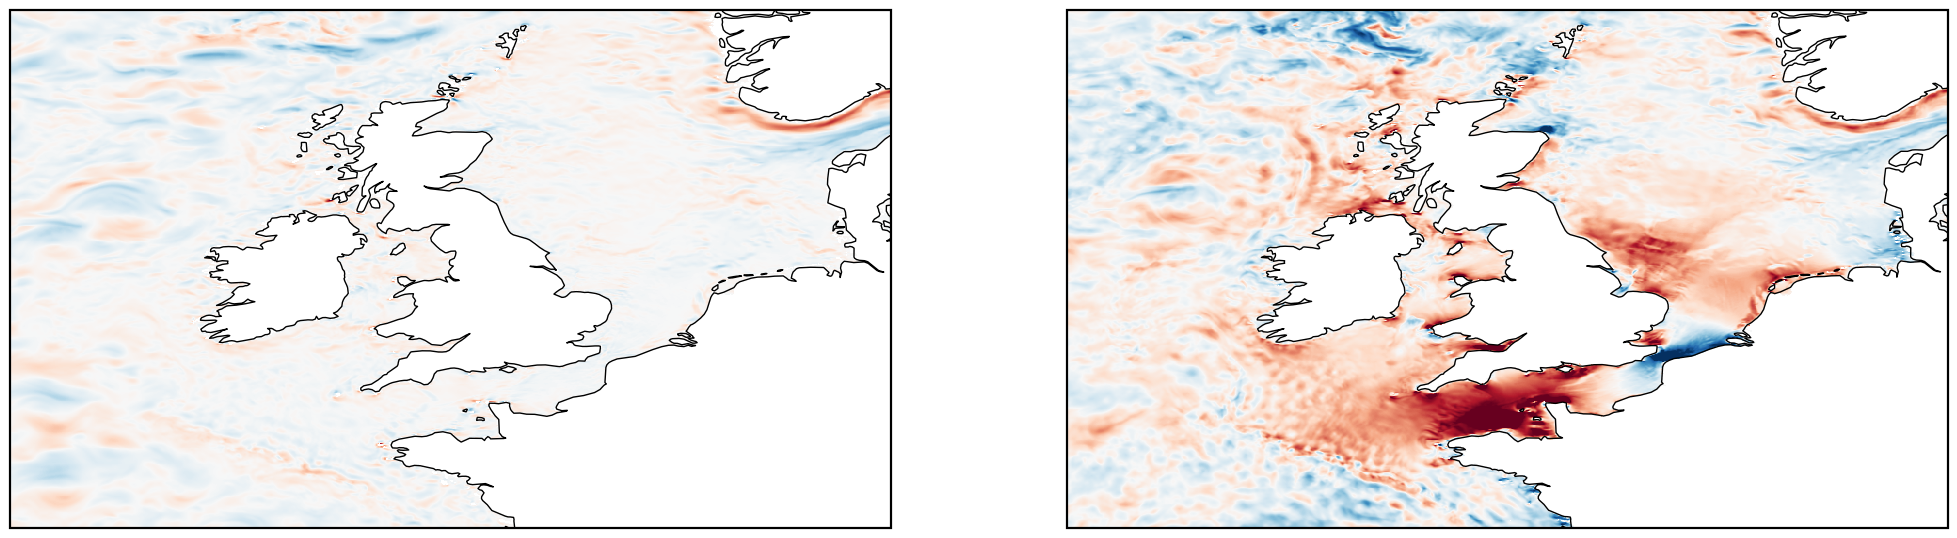

In [64]:
fig, axs = plt.subplots(1,2,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})
axs[0].coastlines()   
axs[1].coastlines()  

axs[0].pcolormesh(LON_daily,LAT_daily,dflow_daily.uo_detided[0],vmin=-1,vmax=1,cmap='RdBu')
axs[1].pcolormesh(LON,LAT,dflow.uo[12],vmin=-1,vmax=1,cmap='RdBu')

In [ ]:
dflow_daily.uo_detided[0].pipe(abs).mean(dim=None,skipna=True).values
dflow.uo_detided[0].pipe(abs).mean(dim=None,skipna=True).values

array(0.0556594, dtype=float32)

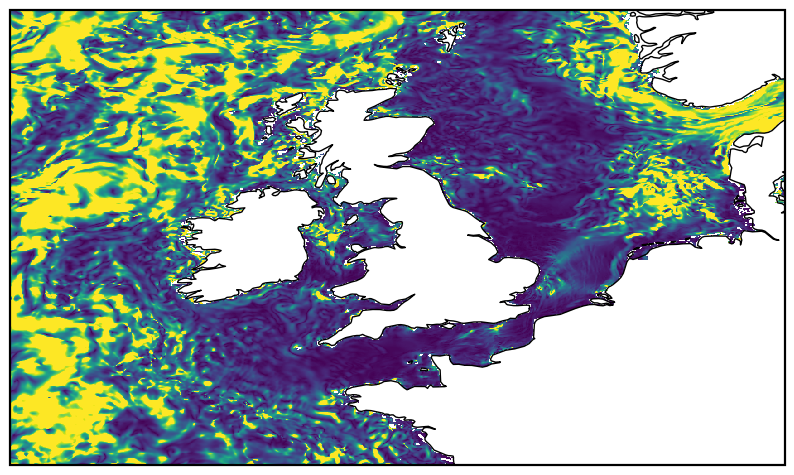

In [61]:
fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()   
ax.pcolormesh(LON_daily,LAT_daily,test,vmin=0,vmax=1)#dflow_daily.uo_detided[0,:,:]/dflow.uo[12,1:,1:])#/dflow.uo[12,2:,:],vmin=0,vmax=1)


In [58]:
test = np.sqrt(dflow_daily.uo_detided[0,:,:].values**2 + dflow_daily.vo_detided[0,:,:].values**2)/np.sqrt(dflow.uo[12,1:,:].values**2+dflow.vo[12,1:,:].values**2)
print(test)

[[1.6892213  1.6086515  1.56435    ...        nan        nan        nan]
 [1.3969777  1.2327869  1.12911    ...        nan        nan        nan]
 [1.1667252  0.99558944 0.8919152  ...        nan        nan        nan]
 ...
 [0.29271355 0.2874095  0.27121675 ...        nan        nan        nan]
 [0.3217356  0.32044944 0.29642266 ...        nan        nan        nan]
 [0.34061933 0.3397017  0.33545387 ...        nan        nan        nan]]


/tmp/ipykernel_2861694/1850747154.py:1: RuntimeWarning: divide by zero encountered in divide
  test = np.sqrt(dflow_daily.uo_detided[0,:,:].values**2 + dflow_daily.vo_detided[0,:,:].values**2)/np.sqrt(dflow.uo[12,1:,:].values**2+dflow.vo[12,1:,:].values**2)


In [40]:
dflow.latitude[-2].values

array(61.25411, dtype=float32)

In [41]:
dflow_daily.latitude[-2].values

array(61.249767, dtype=float32)

In [43]:
dflow.uo.shape


(744, 551, 936)

In [30]:
dflow_daily.uo_detided.shape

(31, 550, 936)